In [700]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing as prep
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and clean the data

In [701]:
# Load the data. The data is from the Our World in Data's github (https://github.com/owid/covid-19-data/tree/master/public/data). downloaded on 10/03/2024
df = pd.read_csv("./Data/owid-covid-data.csv")

In [702]:
# Check that the data is loaded correctly
df.sample(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
230302,NRU,Oceania,Nauru,2021-04-09,NaN,0.0,0.000,NaN,0.0,0.000,...,36.9,NaN,5.0,59.96,NaN,12691.0,NaN,NaN,NaN,NaN
102948,SWZ,Africa,Eswatini,2021-08-06,25979.0,0.0,470.286,787.0,0.0,5.714,...,16.5,24.097,2.1,60.19,0.611,1201680.0,NaN,NaN,NaN,NaN
371249,VNM,Asia,Vietnam,2022-11-14,11508447.0,0.0,405.571,43166.0,0.0,0.000,...,45.9,85.847,2.6,75.40,0.704,98186856.0,NaN,NaN,NaN,NaN
273269,PRI,North America,Puerto Rico,2021-10-12,189545.0,0.0,139.286,3205.0,0.0,3.286,...,NaN,NaN,NaN,80.10,NaN,3252412.0,NaN,NaN,NaN,NaN
290782,VCT,North America,Saint Vincent and the Grenadines,2020-04-01,1.0,0.0,0.000,NaN,0.0,0.000,...,NaN,NaN,2.6,72.53,0.738,103959.0,NaN,NaN,NaN,NaN


In [703]:
# print the columns to see what we have, and later decide what to use
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [704]:
# for hypothesis 1 and 2, we will use the following columns
columns_to_keep = ['iso_code','location', 'total_cases', 'gdp_per_capita', 'population_density', 'population', 'date']

In [705]:
# make a new dataframe with only the columns we want to use
data = df[columns_to_keep]

In [706]:
# check the data to see if it looks good
data.sample(5)

,iso_code,location,total_cases,gdp_per_capita,population_density,population,date
19587,OWID_ASI,Asia,NaN,NaN,NaN,4.721383e+09,2024-02-24
117782,PYF,French Polynesia,11706.0,NaN,77.324,3.062920e+05,2020-11-15
356863,GBR,United Kingdom,336506.0,39753.244,272.898,6.750894e+07,2020-09-04
40567,BOL,Bolivia,1197983.0,6885.829,10.202,1.222411e+07,2023-10-03
245718,PRK,North Korea,NaN,NaN,211.701,2.606942e+07,2022-02-15


In [707]:
# get the percentage of missing values
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code               0.000000
location               0.000000
total_cases           10.239973
gdp_per_capita        22.533775
population_density    15.012879
population             0.000000
date                   0.000000
dtype: float64

In [708]:
# remove the rows with missing values in the total_cases column, because we can't get that data from anywhere else
# and check the missing values again
data = data.dropna(subset=['total_cases'])
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code               0.000000
location               0.000000
total_cases            0.000000
gdp_per_capita        20.135519
population_density    12.718264
population             0.000000
date                   0.000000
dtype: float64

In [709]:
# turn the date column into a datetime object, so it is more useful
data['date'] = pd.to_datetime(data['date'])

In [710]:
# get a list of the iso codes, to see what countries we have data for
iso_codes = data['iso_code'].unique()
iso_codes

array(['AFG', 'OWID_AFR', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATG',
       'ARG', 'ARM', 'ABW', 'OWID_ASI', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR',
       'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL',
       'BES', 'BIH', 'BWA', 'BRA', 'VGB', 'BRN', 'BGR', 'BFA', 'BDI',
       'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN',
       'COL', 'COM', 'COG', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW',
       'CYP', 'CZE', 'COD', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY',
       'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'OWID_EUR', 'OWID_EUN',
       'FRO', 'FLK', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM',
       'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'OWID_HIC', 'HND', 'HUN',
       'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA',
       'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'OWID_KOS', 'KWT',
       'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU

In [711]:
# get owid special codes, which are not countries
iso_codes_owid = data[data['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array(['OWID_AFR', 'OWID_ASI', 'OWID_EUR', 'OWID_EUN', 'OWID_HIC',
       'OWID_KOS', 'OWID_LIC', 'OWID_LMC', 'OWID_NAM', 'OWID_OCE',
       'OWID_SAM', 'OWID_UMC', 'OWID_WRL'], dtype=object)

In [712]:
# remove the owid rows from the data, because we are only interested in countries
data = data[~data['iso_code'].str.contains('OWID')]

In [713]:
# check the data to see if all the owid rows are removed
iso_codes_owid = data[data['iso_code'].str.contains('OWID')]['iso_code'].unique()
iso_codes_owid

array([], dtype=object)

In [714]:
# find any countries that doesnt have any data in the population_density column
# we use the iso code, because it is unique for each country, and other data might have different names for the same country or capital letters for a country 
missing_population_density = data[data['population_density'].isnull()]['iso_code'].unique()
missing_population_density

array(['AIA', 'BES', 'COK', 'FLK', 'GUF', 'GLP', 'GGY', 'JEY', 'MTQ',
       'MYT', 'MSR', 'NIU', 'PCN', 'REU', 'BLM', 'SHN', 'SPM', 'SSD',
       'SYR', 'TKL', 'VAT', 'WLF'], dtype=object)

In [715]:
# load another dataset to so we can fill some of the missing data in the population density column
pop_density = pd.read_csv("./Data/population-density.csv")

In [716]:
# get the first year of the covid dataset
first_year = data['date'].min().year
first_year

2020

In [717]:
# get the last year of the covid dataset
last_year = data['date'].max().year
last_year

2024

In [718]:
# remove rows that are not within the range of the first and last year of the covid dataset
pop_density = pop_density[pop_density['Year'] >= first_year]
pop_density = pop_density[pop_density['Year'] <= last_year]

In [719]:
# check the data to see its size
pop_density.shape

(1220, 4)

In [720]:
# check the data to see if it looks good
pop_density.sample(5)

,Entity,Code,Year,Population density
74921,Wallis and Futuna,WLF,2023,82.36429
68285,Tokelau,TKL,2021,186.90000
26271,Ghana,GHA,2022,147.12534
44041,Micronesia (country),FSM,2022,163.11143
49372,Nigeria,NGA,2022,239.95215


In [721]:
# get the percentage of missing values
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.000000
Code                  4.508197
Year                  0.000000
Population density    0.000000
dtype: float64

In [722]:
# check which rows has missing values in the Code column
pop_density[pop_density['Code'].isnull()]

,Entity,Code,Year,Population density
595,Africa,NaN,2020,45.474545
596,Africa,NaN,2021,46.577396
597,Africa,NaN,2022,47.682274
598,Africa,NaN,2023,48.810062
599,Africa,NaN,2024,49.963478
3884,Asia,NaN,2020,149.983980
3885,Asia,NaN,2021,150.956790
3886,Asia,NaN,2022,151.859040
3887,Asia,NaN,2023,152.838000
3888,Asia,NaN,2024,153.866350


In [723]:
# remove rows with missing values in the Code column, as they are not useful because they are not associated with any country, but rather a region, continent or group of people
# these rows are not useful for our analysis
pop_density = pop_density.dropna(subset=['Code'])

In [724]:
# check the procentage of missing values again
(pop_density.isnull().sum()/pop_density.shape[0])*100

Entity                0.0
Code                  0.0
Year                  0.0
Population density    0.0
dtype: float64

In [725]:
# get the amount of countries in the population density dataset
len(pop_density['Entity'].unique())

233

In [726]:
# rename the population density column to make it easier to work with, when we merge the datasets
pop_density.rename(columns={'Entity':'location', 'Code':'iso_code','Year':'year', 'Population density': 'population_density'}, inplace=True)

In [727]:
# check the columns to see if the renaming was successful
pop_density.sample(5)

,location,iso_code,year,population_density
46188,Mozambique,MOZ,2024,44.327682
26943,Greenland,GRL,2020,0.136555
52646,Palestine,PSE,2024,912.785200
69952,Turkmenistan,TKM,2022,13.684543
65763,Sweden,SWE,2021,25.699778


In [728]:
# find out if the countries in the covid dataset, with missing population_density, are in the population density dataset
doesnt_exists = []
for code in missing_population_density:
    if not code in pop_density['iso_code'].unique():
        doesnt_exists.append(code)

print(len(doesnt_exists), len(missing_population_density))
print(doesnt_exists)
# this means that there is 5 countries in the covid dataset, with missing population_density, that are not in the population density dataset

5 22
['GGY', 'JEY', 'PCN', 'BLM', 'VAT']


In [729]:
# remove the countries that are not in the population density dataset from the covid dataset
data = data[~data['iso_code'].isin(doesnt_exists)]

In [730]:
# Next we will fill in the missing population density data, by using the population density dataset and a new dataframe as an intermediary
# we do this by finding the population density data for the countries with missing population density, and then put it into a new dataframe
rows_with_missing_pop_density = data[data['population_density'].isnull()]
df_with_pop_filled = pd.DataFrame(columns=data.columns)
for row in rows_with_missing_pop_density.iterrows():
    index = row[0]
    row = row[1]
    year = row['date'].year
    location = row['location']
    iso_code = row['iso_code']
    year_condition = pop_density['year'] == year
    iso_code_condition = pop_density['iso_code'] == iso_code
    combined_condition = year_condition & iso_code_condition
    pop_density_row = pop_density[combined_condition]
    #print(f"putting data into index: {index}")
    df_with_pop_filled.loc[index] = [iso_code, location, row['total_cases'], row['gdp_per_capita'], pop_density_row['population_density'].values[0], row['population'], row['date']]


In [731]:
# put the data from the intermediary dataframe into the original covid dataframe at the correct index
data['population_density'] = data['population_density'].fillna(df_with_pop_filled['population_density'])

In [732]:
# drop the rows with missing values in the gdp_per_capita column, because we can't get that data from anywhere else that is up to date
data = data.dropna(subset=['gdp_per_capita'])

In [733]:
# get the percentage of missing values
missing_values = (data.isnull().sum()/data.shape[0])*100
missing_values

iso_code              0.0
location              0.0
total_cases           0.0
gdp_per_capita        0.0
population_density    0.0
population            0.0
date                  0.0
dtype: float64

# Hypotese 1

### Vi tror at der er en sammenhængen mellem antal smittede i forholds til et lands Bruttonationalprodukt (BNP) per indbygger.

In [734]:
# Copy the covid data to use for hypothesis 1
data_hypothesis_1 = data[['location', 'total_cases', 'gdp_per_capita', 'date', 'population']]

In [735]:
# get an overview of the data
data_hypothesis_1.describe()

,total_cases,gdp_per_capita,date,population
count,2.697960e+05,269796.000000,269796,2.697960e+05
mean,2.160130e+06,19006.496458,2022-03-08 00:11:38.127473664,4.270844e+07
min,1.000000e+00,661.240000,2020-01-05 00:00:00,1.133500e+04
25%,1.362000e+04,4227.630000,2021-03-15 18:00:00,2.119843e+06
50%,1.208480e+05,12895.635000,2022-03-14 00:00:00,8.939617e+06
75%,8.948930e+05,27717.847000,2023-03-02 00:00:00,3.347587e+07
max,1.034368e+08,116935.600000,2024-02-18 00:00:00,1.425887e+09
std,8.324078e+06,19569.781223,NaN,1.539488e+08


In [739]:
# get the last row for each country/ lastest observation
last_row = data_hypothesis_1.groupby('location').last().reset_index()
last_row.sample(5)

,location,total_cases,gdp_per_capita,date,population
110,Micronesia (country),26547.0,3299.464,2024-02-18,114178.0
135,Philippines,4140383.0,7599.188,2024-02-18,115559008.0
21,Bolivia,1198016.0,6885.829,2024-02-18,12224114.0
154,Singapore,3001665.0,85535.383,2024-02-18,5637022.0
63,Gambia,12626.0,1561.767,2024-02-18,2705995.0


In [737]:
# check if the last row for each country has the same date
last_row['date'].max() == last_row['date'].min()

True

In [ ]:
# graph of the cumulative cases per country
# here we create a subset of the data to use for the graph, where it is sorted by the total_cases
data_hypothesis_1_subset = last_row.sort_values('total_cases', ascending=False)
plt.figure(figsize=(200,100))
sns.barplot(x='location', y='total_cases', data=data_hypothesis_1_subset)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# WIP, mouse over event for the scatter plot to show the country name
# doesnt work yet
def mouse_over_event(event):
    # Iterating over each data member plotted
    for curve in plot.get_lines():
        # Searching which data member corresponds to current mouse position
        if curve.contains(event)[0]:
            print(curve.get_label())

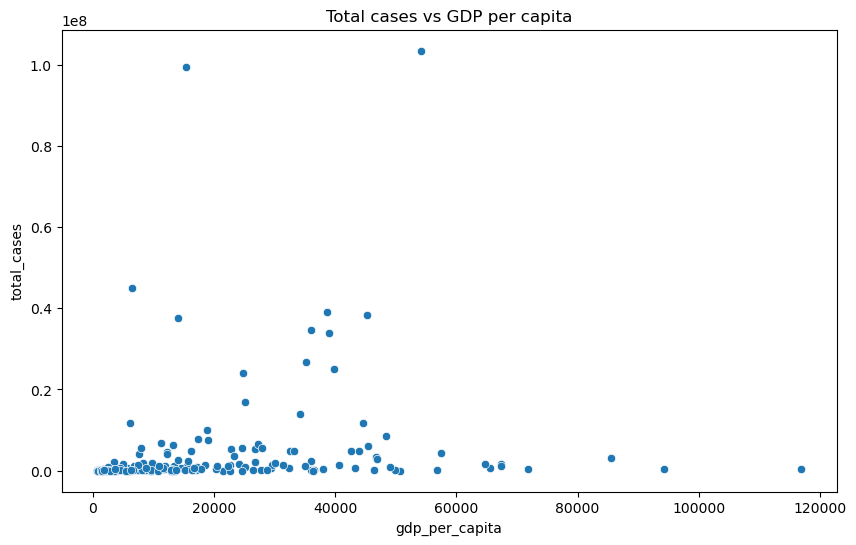

In [ ]:
# scatterplot wherex is gdp_per_capita and y is total_cases for each country
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gdp_per_capita', y='total_cases', data=last_row)
plt.title('Total cases vs GDP per capita')
#fig.canvas.mpl_connect('motion_notify_event', lambda event: print())
plt.show()

### Here we can see the each country's BNP per capita and the number of infected people in the country. We can also see that there is 3 outliers in the data. These are (China), (USA) and (Italy). We will remove these from the data to get a better overview of the data.

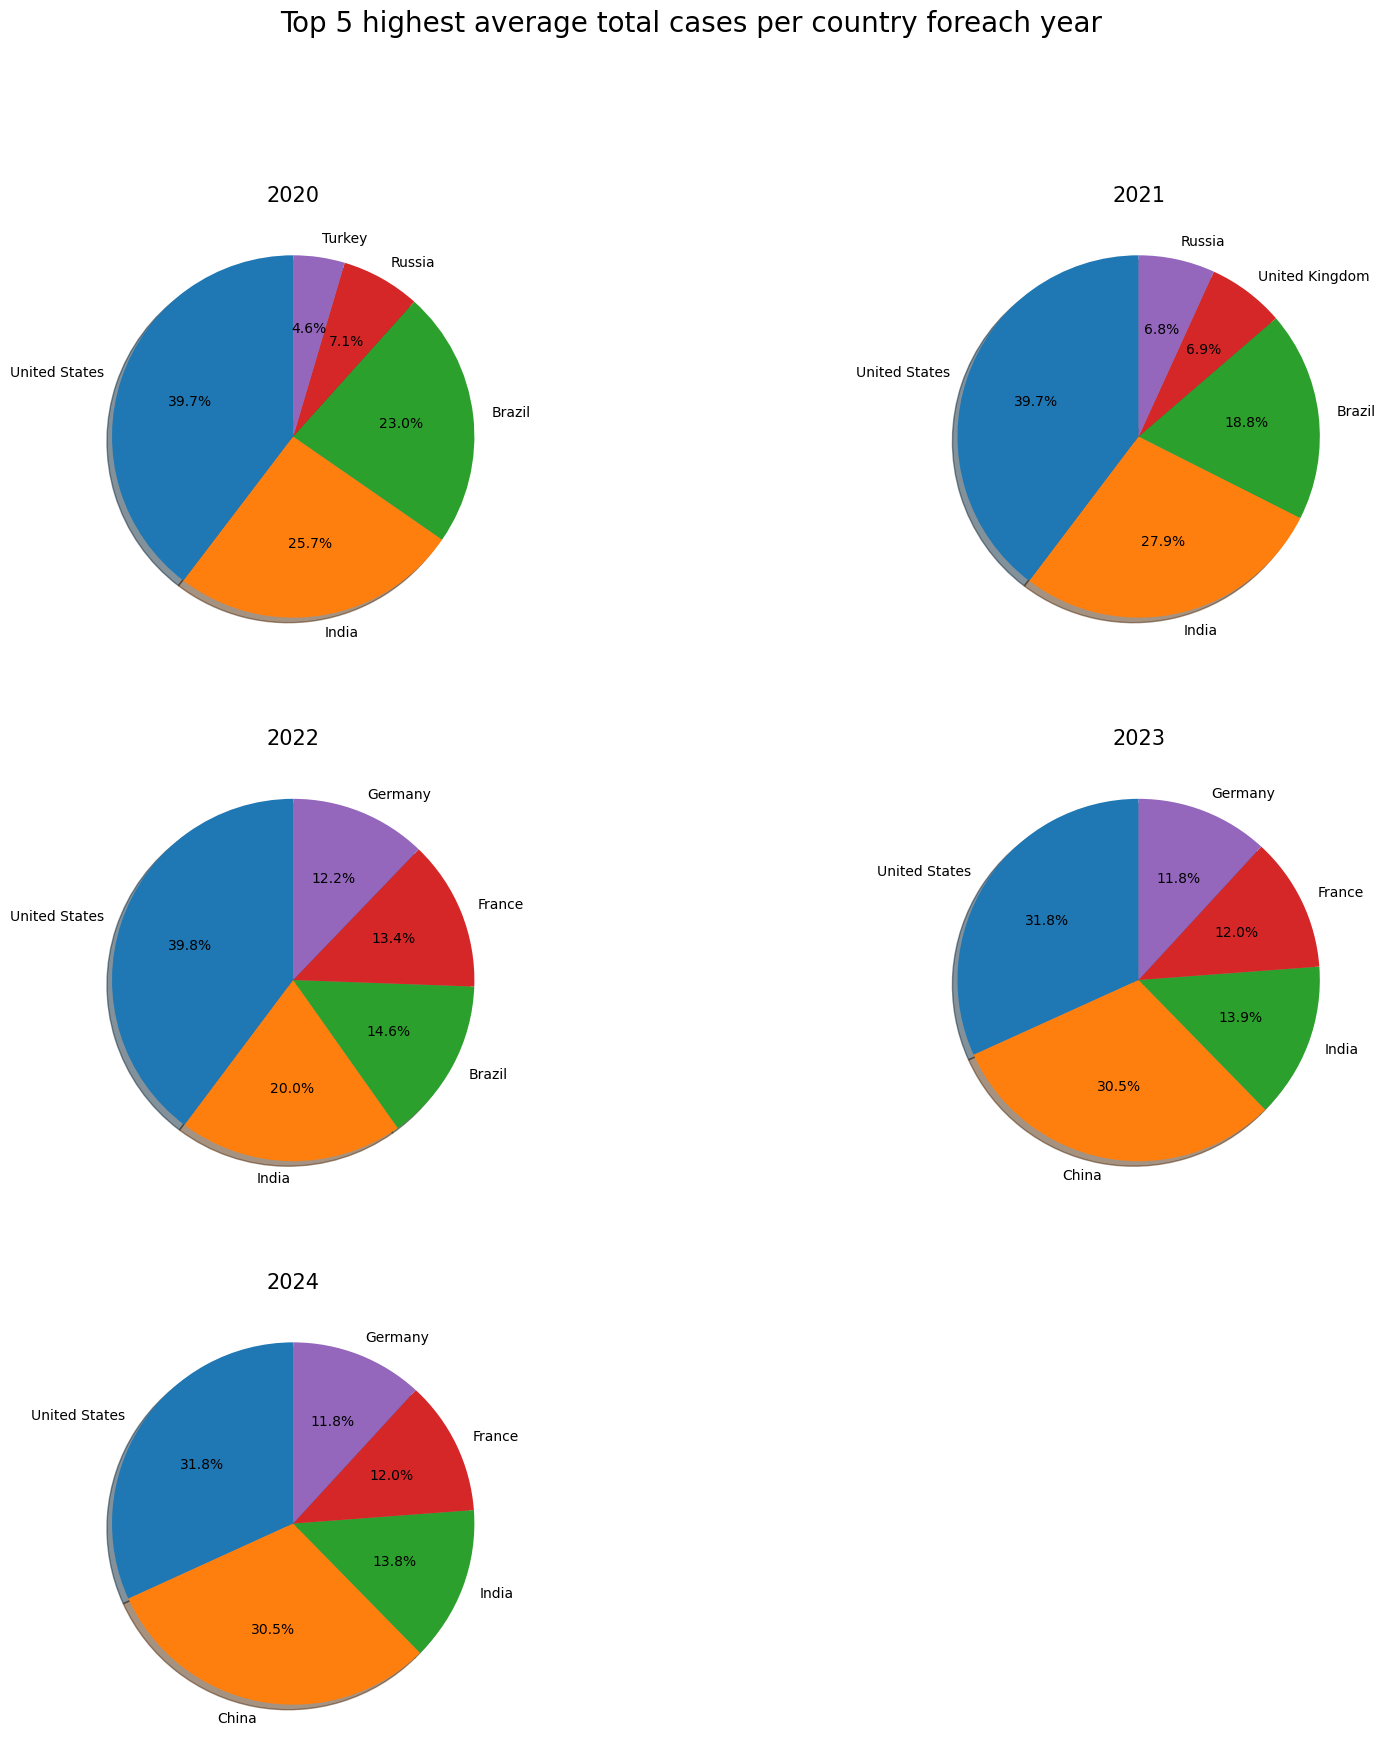

In [ ]:
# show a piechart of the top 5 countries with the highest average total cases for each year that we have data for, in a single graph
fig = plt.figure(figsize=(20, 20))

for i, y in enumerate(years, start=1):
    plt.subplot(3, 2, i)
     # get the avg total cases per country for the year
    avg_total_cases = data_hypothesis_1[data_hypothesis_1['date'].dt.year == y].groupby('location')['total_cases'].mean()
    avg_total_cases = avg_total_cases.reset_index()
    avg_total_cases = avg_total_cases.sort_values(by='total_cases', ascending=False)
    # get the top 5 countries
    top_5 = avg_total_cases.head(5)
    plt.pie(top_5['total_cases'], labels=top_5['location'], autopct='%.1f%%',
            startangle=90, shadow=True)
    plt.title(y, fontsize=15)

plt.suptitle('Top 5 highest average total cases per country foreach year', fontsize=20)
plt.show()

# Hypotese 2